This notebook to train sequence to sequence model for Arabic punctuation prediction. This project followed the [Neural Machine Translation]((https://www.tensorflow.org/tutorials/text/nmt_with_attention)) which available from TensorFlow.


### Import necessary libraries




In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.utils import shuffle

import numpy as np
import os
import time
import pandas as pd
import keras
from nltk.translate.bleu_score import corpus_bleu
from time import sleep
import sys

from tqdm import tqdm

2023-04-11 20:59:14.470762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 20:59:14.661436: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-11 20:59:14.662676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-11 20:59:15.637683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Prepare data
In this step, we convert input and output files to numeric sequence with length 10 as the maximum length.

In [3]:
def preprocess_sentence(file_name):
    '''
    DESCRIPTION:
    This function to read the file, then add <start> and <end> as a tag in begin and end for each sequence.
    INPUT: 
    file_name: file name
    OUTPUT: 
    text: text after preprocess
    ''' 
    with open(file_name , 'r', encoding='windows-1256') as f:
        text = f.readlines()

    text = ['<start> '+ t.replace('\n','') + ' <end>' for t in text]
    return text


def calculate_max_length(tensor):
    '''
    DESCRIPTION:
    This function to Calculates the max length in tensor
    INPUT: 
    tensor: input tensor
    OUTPUT: 
    _: max length of tensor
    ''' 
    return max(len(t) for t in tensor)

def tokenize(text):
    '''
    DESCRIPTION:
    This function to convert inputs to numeric sequences with the maximum length
    INPUT: 
    text: list of string
    OUTPUT: 
    tokenizer: object of converted text into a sequence of integer
    text_vector: vector of converted text into a sequence of integer
    max_length: max length in text_vector
    ''' 

    # Choose the top 9000 words from the vocabulary
    top_k = 9000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>",filters='')
    tokenizer.fit_on_texts(text)
    train_seqs = tokenizer.texts_to_sequences(text)

    #add a word for padding 
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Create the tokenized vectors
    text_seqs = tokenizer.texts_to_sequences(text)

    # Pad each vector to the max_length of the vector
    text_vector = tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding='post')

    # Calculates the max_length, which is used to store the attention weights
    max_length = calculate_max_length(text_seqs)
    
    return tokenizer, text_vector,max_length

In [4]:
# prepare input data
input = preprocess_sentence('input_pun')
input_tokenizer, input_tensor ,input_max_length = tokenize(input)

In [5]:
# prepare output data
target = preprocess_sentence('output_pun')
target_tokenizer, target_tensor ,target_max_length = tokenize(target)

In [6]:
# data shapes
(input_tensor.shape),(target_tensor.shape) 

((26000, 12), (26000, 12))

In [7]:
def convert(tokenizer, tensor):
    '''
    DESCRIPTION:
    This function to convert index to word for input tensor
    INPUT: 
    tokenizer: object of converted text into a sequence of integer
    tensor: list of integer
    OUTPUT: 
    None
    ''' 
    for t in tensor:
        if t!=0:
              print ("%d ----> %s" % (t, tokenizer.index_word[t]))
    
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor[0])  
print ("Output Language; index to word mapping")
convert(target_tokenizer, target_tensor[0]) 

Input Language; index to word mapping
2 ----> <start>
2760 ----> تم
7016 ----> إعداد
39 ----> هذا
1 ----> <unk>
1 ----> <unk>
3667 ----> بواسطة
1 ----> <unk>
7017 ----> الشاملة
1956 ----> الكتاب
48 ----> شرح
3 ----> <end>
Output Language; index to word mapping
3 ----> <start>
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
2 ----> space
5 ----> :
2 ----> space
4 ----> <end>


### Data Visualization

In [8]:
target_plot = pd.DataFrame(list(target_tokenizer.word_counts.items())) 
target_plot

,0,1
0,<start>,26000
1,space,218354
2,:,12962
3,<end>,26000
4,.,12259
5,؛,3601
6,،,12614
7,؟,210


<BarContainer object of 8 artists>

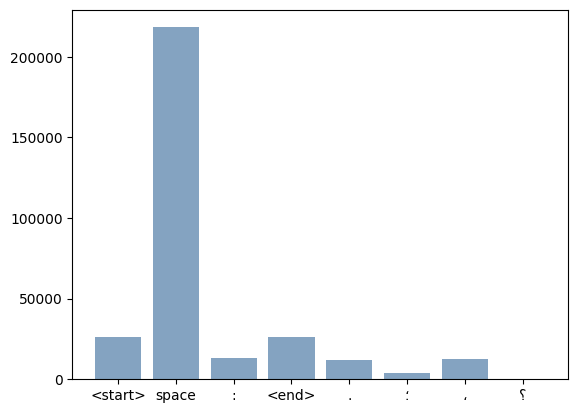

In [9]:
plt.xticks(fontsize =10)
plt.bar(target_plot[0],target_plot[1], color=(0.2, 0.4, 0.6, 0.6))

### Create dataset

In [10]:
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 256
steps_per_epoch = len(input_tensor)//BATCH_SIZE
embedding_dim = 128
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

# create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor, target_tensor)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

2023-04-11 20:59:20.786809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-11 20:59:20.787377: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

2023-04-11 20:59:20.905835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]
2023-04-11 20:59:20.906299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]


(TensorShape([256, 12]), TensorShape([256, 12]))

## Encoder and decoder model

In this part of the code, we used the same technique of Neural Machine Translation provided by TensorFlow. However, we used Keras with the backend of TensorFlow. For more details can visit [Neural machine translation with attention tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention).

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.keras.layers.Activation(activation = "tanh")(tf.keras.layers.Add()([self.W1(values), self.W2(hidden_with_time_axis)])))    

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.keras.layers.Activation(activation = "softmax")(tf.keras.layers.Permute((2, 1))(score))
        attention_weights = tf.keras.layers.Permute((2, 1))(attention_weights)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.keras.layers.Multiply()([attention_weights, values])

        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.keras.layers.Concatenate(axis = -1)([tf.expand_dims(context_vector, 1), x])

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        #output = tf.keras.layers.Dense(self.dec_units)(output)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.keras.layers.Reshape((output.shape[2],))(output)

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [15]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)


attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)



### Optimizer and loss function

In [16]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [17]:
checkpoint_dir = './training_checkpoints5'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Train

In [18]:

@tf.function
def train_step(inp, targ, enc_hidden):
    '''
    DESCRIPTION:
    This function to train encode-decode model
    INPUT: 
    inp: input vector
    targ: target vector
    enc_hidden: encoder initial hidden state
    OUTPUT: 
    batch_loss: train loss
    ''' 

    loss = 0
    accuracy = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [19]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2023-04-11 20:59:21.896201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]
2023-04-11 20:59:21.896461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]
2023-04-11 20:59:22.329919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

Epoch 1 Batch 0 Loss 2.1993
Epoch 1 Batch 100 Loss 0.7556
Epoch 1 Loss 0.8562
Time taken for 1 epoch 229.7001552581787 sec



2023-04-11 21:03:11.592988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]
2023-04-11 21:03:11.593255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]


Epoch 2 Batch 0 Loss 0.7449
Epoch 2 Batch 100 Loss 0.6959
Epoch 2 Loss 0.7132
Time taken for 1 epoch 219.21280789375305 sec



2023-04-11 21:06:50.805913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]
2023-04-11 21:06:50.806271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]


Epoch 3 Batch 0 Loss 0.7046
Epoch 3 Batch 100 Loss 0.4236
Epoch 3 Loss 0.6023
Time taken for 1 epoch 225.6610176563263 sec



2023-04-11 21:10:36.466760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]
2023-04-11 21:10:36.466986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]


Epoch 4 Batch 0 Loss 0.4407
Epoch 4 Batch 100 Loss 0.4567
Epoch 4 Loss 0.4288
Time taken for 1 epoch 231.9077010154724 sec



2023-04-11 21:14:28.375367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]
2023-04-11 21:14:28.375754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]


Epoch 5 Batch 0 Loss 0.3097
Epoch 5 Batch 100 Loss 0.2494
Epoch 5 Loss 0.2854
Time taken for 1 epoch 230.88640785217285 sec



2023-04-11 21:18:19.261054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]
2023-04-11 21:18:19.261301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]


Epoch 6 Batch 0 Loss 0.2185
Epoch 6 Batch 100 Loss 0.2968
Epoch 6 Loss 0.4244
Time taken for 1 epoch 232.37510895729065 sec



2023-04-11 21:22:11.636112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]
2023-04-11 21:22:11.636375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]


Epoch 7 Batch 0 Loss 0.2515
Epoch 7 Batch 100 Loss 0.2029
Epoch 7 Loss 0.2194
Time taken for 1 epoch 232.16049456596375 sec



2023-04-11 21:26:03.796622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_1}}]]
2023-04-11 21:26:03.796886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]


Epoch 8 Batch 0 Loss 0.1899
Epoch 8 Batch 100 Loss 0.2177
Epoch 8 Loss 0.4324
Time taken for 1 epoch 229.85103964805603 sec



2023-04-11 21:29:53.651152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]
2023-04-11 21:29:53.651517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]


Epoch 9 Batch 0 Loss 0.2055
Epoch 9 Batch 100 Loss 0.2042
Epoch 9 Loss 0.2574
Time taken for 1 epoch 235.27777314186096 sec



2023-04-11 21:33:48.925359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]
2023-04-11 21:33:48.925597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [26000,12]
	 [[{{node Placeholder/_0}}]]


Epoch 10 Batch 0 Loss 0.1808
Epoch 10 Batch 100 Loss 0.1708
Epoch 10 Loss 0.1788
Time taken for 1 epoch 233.34447646141052 sec



In [20]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Predict

In [21]:
def evaluate(sentence):
    '''
    DESCRIPTION:
    This function to predict result
    INPUT: 
    sentence: input sentence 
    OUTPUT: 
    result: predict result
    sentence: input sentence 
    attention_plot: attention weights
    ''' 
    attention_plot = np.zeros((target_max_length, input_max_length))

    #sentence = preprocess_sentence(sentence)
    sentence = '<start> '+sentence + ' <end>'
    
    inputs = [input_tokenizer.texts_to_sequences([i])[0][0] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_max_length,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for t in range(target_max_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [22]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  '''
    DESCRIPTION:
    This function to plot attention 
    INPUT: 
    attention: attention weights
    sentence: input sentence 
    predicted_sentence: predict result

    OUTPUT: 
    None
    ''' 
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [23]:
def predict(sentence):
    '''
    DESCRIPTION:
    This function to predict output sentence

    INPUT: 
    sentence: input sentence 

    OUTPUT: 
    None
    ''' 
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:\n %s' % (sentence))

    predict = ''
    sentence_list = sentence.split(' ')
    sentence_list.pop(0) # remove <start>
    result_list = result.split(' ')

    for i in range(len(sentence_list)):
      if (result_list[i]=='space'):
        predict += sentence_list[i]+' '
      else:
        predict += sentence_list[i]+result_list[i]+' '
    print('Predicted punctuation:\n {}'.format(predict))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence_list, result_list)

Original Text:  .قال محمد : السلام عليكم
Input:
 <start> نجح محمد في الامتحان لأنه اجتهد في دروسه <end>
Predicted punctuation:
 نجح محمد في الامتحان؛ لأنه اجتهد في دروسه <end> 


/tmp/ipykernel_4406/2895767645.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_4406/2895767645.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


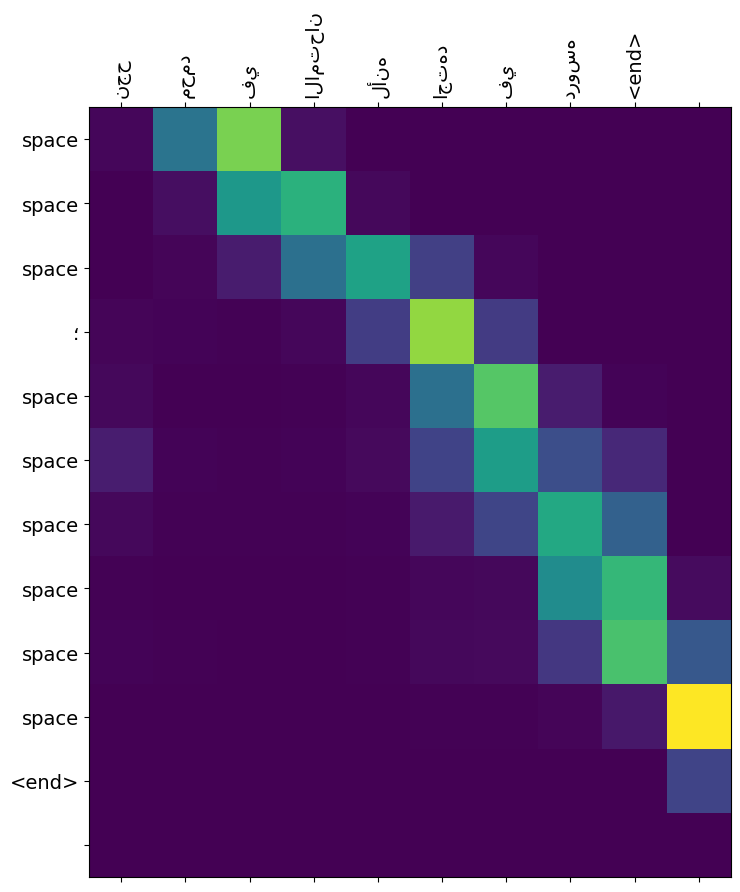

[None]

In [34]:
real_sentence = '.قال محمد : السلام عليكم'
#real_sentence = 'نجح محمد في الامتحان ؛ لأنه اجتهد في دروسه.'
sentence = 'نجح محمد في الامتحان لأنه اجتهد في دروسه'
print('Original Text: ',real_sentence)

in_seq = sentence.strip().split(' ')
n = 10
in_sequances = [" ".join(in_seq[i:i+n]) for i in range(0, len(in_seq), n)]
[predict(s) for s in in_sequances]

In [25]:

def evaluate_model(sentences, target):
  '''
  DESCRIPTION:
  This function to evaluate model 
  INPUT: 
  sentences: input vector
  target: target vector
  OUTPUT: 
  actual: real target sentences
  predicted: predict target sentences
  ''' 
  actual, predicted = list(), list()
  outer = tqdm(range(len(sentences)), leave=True, position=0)
  for i, sentence in enumerate(sentences):
    # translate encoded source text
    #sentence = sentence.reshape((1, sentence.shape[0]))
    predict, raw_src, _ = evaluate(sentence)
    predict = predict.replace(' <end> ', '')
    raw_target = target[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (sentence, raw_target, predict))
    actual.append([raw_target.split()])
    predicted.append(predict.split())
    outer.update(1)

  return actual, predicted



In [26]:
input_ = np.array(input)
input_ = [ t.replace(' <end>', '') for t in input_]
input_ = [ t.replace('<start> ', '') for t in input_]

target_ = np.array(target)
target_ = [ t.replace(' <end>', '') for t in target_]
target_ = [ t.replace('<start> ', '') for t in target_]

actual, predicted = evaluate_model(input_, target_)

  0%|          | 1/26000 [00:00<1:41:44,  4.26it/s]

src=[تم إعداد هذا الملف آليا بواسطة المكتبة الشاملة الكتاب شرح], target=[space space space space space space space space : space], predicted=[space space space space space space space space : space]


  0%|          | 2/26000 [00:00<1:41:30,  4.27it/s]

src=[البهجة الوردية مصدر الكتاب موقع الإسلام [ الكتاب مشكول ومرقم], target=[space space space : space space space space space space], predicted=[space space space : space space space space space space]


  0%|          | 3/26000 [00:00<1:42:10,  4.24it/s]

src=[على سيدنا محمد وعلى آله وصحبه وسلم تسليما كثيرا رب], target=[space space space space space space space space . space], predicted=[space space space space space space space space . space]


  0%|          | 4/26000 [00:00<1:42:11,  4.24it/s]

src=[يسر واعف واختم بخير قال الشيخ الإمام العالم العلامة الرحالة], target=[space space space . space space space space space space], predicted=[space space space space space space space space space space]


  0%|          | 5/26000 [00:01<1:42:32,  4.23it/s]

src=[بسم الله الرحمن الرحيم أي أبتدئ أو أؤلف إذ كل], target=[space space space space : space space space space space], predicted=[space space space space : space space space space space]


  0%|          | 6/26000 [00:01<1:42:47,  4.21it/s]

src=[فاعل يبدأ في فعله ببسم الله يضمر ما جعل التسمية], target=[space space space space space . space space space space], predicted=[space space space space space . space space space space]


  0%|          | 7/26000 [00:01<1:41:53,  4.25it/s]

src=[مبدأ له كما أن المسافر إذا حل أو ارتحل فقال], target=[space space space space space space space space space :], predicted=[space space space space space space space space space :]


  0%|          | 8/26000 [00:01<1:42:12,  4.24it/s]

src=[والاسم مشتق من السمو وهو العلو وقيل من الوسم وهو], target=[space space space space space space : space space space], predicted=[space space space ، space space : space space space]


  0%|          | 9/26000 [00:02<1:41:46,  4.26it/s]

src=[العلامة لأن كل ما سمي فقد نوه باسمه ووسم والله], target=[؛ space space space space space space space . space], predicted=[؛ space space space space space space space space space]


  0%|          | 10/26000 [00:02<1:41:34,  4.26it/s]

src=[علم للذات الواجب الوجود وأصله الإله حذفت همزته وعوض منها], target=[space space space ، space space space space space space], predicted=[space space space ، space space space space space space]


100%|██████████| 26000/26000 [1:39:50<00:00,  4.34it/s]  


In [27]:
# calculate BLEU score
print('BLEU: %f' % corpus_bleu(actual, predicted))

BLEU: 0.881263


In [35]:
checkpoint.save('my_model')  # Save the model to a file

'my_model-7'